In [ ]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#from moviepy.editor import VideoFileClip
from collections import deque

def binary_threshold(img, low, high):
    if len(img.shape) == 2:
        output = np.zeros_like(img)
        mask = (img >= low) & (img <= high)

    elif len(img.shape) == 3:
        output = np.zeros_like(img[:,:,0])
        mask = (img[:,:,0] >= low[0]) & (img[:,:,0] <= high[0]) \
            & (img[:,:,1] >= low[1]) & (img[:,:,1] <= high[1]) \
            & (img[:,:,2] >= low[2]) & (img[:,:,2] <= high[2])

    output[mask] = 1
    return output

def pipeline_threshold(img, visualise=False):

    ### LAB color space
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    L = lab[:,:,0]
    L_max, L_mean = np.max(L), np.mean(L)
    B = lab[:,:,2]
    B_max, B_mean = np.max(B), np.mean(B)

    # YELLOW
    L_adapt_yellow = max(80, int(L_max * 0.45))
    B_adapt_yellow =  max(int(B_max * 0.70), int(B_mean * 1.2))
    lab_low_yellow = np.array((L_adapt_yellow, 120, B_adapt_yellow))
    lab_high_yellow = np.array((255, 145, 255))

    lab_yellow = binary_threshold(lab, lab_low_yellow, lab_high_yellow)
    lab_binary =lab_yellow

    ### HSV color space
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    H = hsv[:,:,0]
    H_max, H_mean = np.max(H), np.mean(H)
    S = hsv[:,:,1]
    S_max, S_mean = np.max(S), np.mean(S)
    V = hsv[:,:,2]
    V_max, V_mean = np.max(V), np.mean(V)

    # YELLOW
    S_adapt_yellow =  max(int(S_max * 0.25), int(S_mean * 1.75))
    V_adapt_yellow =  max(50, int(V_mean * 1.25))
    hsv_low_yellow = np.array((15, S_adapt_yellow, V_adapt_yellow))

    hsv_high_yellow = np.array((30, 255, 255))
    hsv_yellow = binary_threshold(hsv, hsv_low_yellow, hsv_high_yellow)

    # WHITE
    V_adapt_white = max(150, int(V_max * 0.8),int(V_mean * 1.25))
    hsv_low_white = np.array((0, 0, V_adapt_white))
    hsv_high_white = np.array((255, 40, 220))

    hsv_white = binary_threshold(hsv, hsv_low_white, hsv_high_white)

    hsv_binary = hsv_yellow | hsv_white

    ### HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    L = hls[:,:,1]
    L_max, L_mean = np.max(L), np.mean(L)
    S = hls[:,:,2]
    S_max, S_mean = np.max(S), np.mean(S)

    # YELLOW
    L_adapt_yellow = max(80, int(L_mean * 1.25))
    S_adapt_yellow = max(int(S_max * 0.25), int(S_mean * 1.75))
    hls_low_yellow = np.array((15, L_adapt_yellow, S_adapt_yellow))
    hls_high_yellow = np.array((30, 255, 255))

    hls_yellow = binary_threshold(hls, hls_low_yellow, hls_high_yellow)

    # WHITE
    L_adapt_white =  max(160, int(L_max *0.8),int(L_mean * 1.25))
    hls_low_white = np.array((0, L_adapt_white,  0))
    hls_high_white = np.array((255, 255, 255))

    hls_white = binary_threshold(hls, hls_low_white, hls_high_white)

    hls_binary = hls_yellow | hls_white

    ### R color channel (WHITE)
    R = img[:,:,0]
    R_max, R_mean = np.max(R), np.mean(R)

    R_low_white = min(max(150, int(R_max * 0.55), int(R_mean * 1.95)),230)
    R_binary = binary_threshold(R, R_low_white, 255)

    combined = np.asarray(R_binary + lab_binary + hls_binary + hsv_binary, dtype=np.uint8)

    combined[combined < 2] = 0
    combined[combined >= 2] = 1
    #kernel_size = 5
    #combined = cv2.GaussianBlur(combined, (kernel_size, kernel_size), 0)

    return  combined

def perspective_transform(img):
    h,w = img.shape[:2]
    rows, cols = img.shape[:2]
    

    src = np.float32([[cols*0.01, rows*0.98],[cols*0.1, rows*0.12],
                      [cols*0.8, rows*0.12],[cols*0.99, rows*0.98]])

    

    dst = np.float32([[50, img.shape[0]], [50, 0],
                      [550, 0], [550, img.shape[0]]])


    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, (w,h), flags=cv2.INTER_LINEAR)
    return warped, M, Minv, src

def perspective_transform_helper(img):
    warped,_,_,_ = perspective_transform(img)
    return warped


def create_xy_for_plotting(height, left_fit, right_fit):
    ploty = np.linspace(0, height-1, height)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    return ploty, left_fitx, right_fitx

def sliding_window_polynomial_fit(binary_warped, show_image=False, nwindows = 19):
    
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    window_height = np.int(binary_warped.shape[0]/nwindows)
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    leftx_current = leftx_base
    rightx_current = rightx_base
    margin = 100
    minpix = 50
    left_lane_inds = []
    right_lane_inds = []

    for window in range(nwindows):
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    left_fit, right_fit = (None, None)
    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)

    if left_fit is not None and right_fit is not None:
        ploty, left_fitx, right_fitx = create_xy_for_plotting(binary_warped.shape[0], left_fit, right_fit)

    return left_fit, right_fit


def polynomialfit_from_previous(binary_warped, left_fit_prev, right_fit_prev):
    left_fit, right_fit = (None, None)
    if left_fit_prev is None or right_fit_prev is None:
        return left_fit, right_fit
    
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy +
    left_fit_prev[2] - margin)) & (nonzerox < (left_fit_prev[0]*(nonzeroy**2) +
    left_fit_prev[1]*nonzeroy + left_fit_prev[2] + margin)))

    right_lane_inds = ((nonzerox > (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy +
    right_fit_prev[2] - margin)) & (nonzerox < (right_fit_prev[0]*(nonzeroy**2) +
    right_fit_prev[1]*nonzeroy + right_fit_prev[2] + margin)))

    
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    
    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)
    return left_fit, right_fit


def get_curvature(width, ploty, left_fitx, right_fitx):
    
    ym_per_pix = 0.5/600 # meters per pixel in y dimension
    xm_per_pix = 0.15/320 # meters per pixel in x dimension

    
    y_eval = np.max(ploty)

    
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)

    
    radius_left_lane =  ((1 + (2*left_fit_cr[0] *y_eval*ym_per_pix + left_fit_cr[1])**2) **1.5)/np.absolute(2*left_fit_cr[0])
    radius_right_lane = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5)/np.absolute(2*right_fit_cr[0])

    car_position = width / 2
    lane_center = (left_fitx[359] + right_fitx[359]) / 2

    vehicle_offset = (lane_center-car_position)*xm_per_pix

    radius_of_curvature = np.mean([radius_left_lane, radius_right_lane])
    return radius_of_curvature, vehicle_offset

def draw_lane_quadrilateral(undist, warped, Minv, left_fit, right_fit):
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    ploty, left_fitx, right_fitx = create_xy_for_plotting(warped.shape[0], left_fit, right_fit)

    
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    
    newwarp = cv2.warpPerspective(color_warp, Minv, (warped.shape[1], warped.shape[0]))
    
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)

    radius_of_curvature, vehicle_offset = get_curvature(warped.shape[1], ploty, left_fitx, right_fitx)
    return result, radius_of_curvature, vehicle_offset
    #return radius_of_curvature, vehicle_offset
    #return result, left_fit, right_fit

"""def pipeline_to_process_image(image, left_fit_prev=None, right_fit_prev=None):
    warped, _, Minv, _ = perspective_transform(pipeline_threshold(image))
    left_fit, right_fit = polynomialfit_from_previous(warped, left_fit_prev, right_fit_prev)
    if left_fit is None or right_fit is None:
        print("None")
        left_fit, right_fit = sliding_window_polynomial_fit(warped, show_image=False)
    if left_fit is not None and right_fit is not None:
        print("Not None")
        return draw_lane_quadrilateral(image, warped, Minv, left_fit, right_fit)
    print("prank")
    return image, left_fit, """
left_fit_prev=None 
right_fit_prev=None
image = mpimg.imread('test_images2/test6.jpg')
warped, _, Minv, _ = perspective_transform(pipeline_threshold(image))
left_fit, right_fit = polynomialfit_from_previous(warped, left_fit_prev, right_fit_prev)
if left_fit is None or right_fit is None:
    print("None")
    left_fit, right_fit = sliding_window_polynomial_fit(warped, show_image=False)
if left_fit is not None and right_fit is not None:
    print("Not None")
    result, curvature, offset = draw_lane_quadrilateral(image, warped, Minv, left_fit, right_fit)
    print("vehicle_offset: ", offset)
    print("radius_of_curvature", curvature)
    cv2.imshow("result", result)
    cv2.waitKey(0)
    print("prank")


i=0
#while(i<10):
#img = mpimg.imread('test_images2/test6.jpg')
#result, curvature, offset = pipeline_to_process_image(img)
#print("vehicle_offset: ", offset)
#print("radius_of_curvature", curvature)
#cv2.imshow("result", result)
#cv2.waitKey(0)
#img = mpimg.imread('test_images2/test9.jpg')
#result, curvature, offset = pipeline_to_process_image(img)
#print("vehicle_offset: ", offset)
#print("radius_of_curvature", curvature)
#i=i+1


In [ ]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#from moviepy.editor import VideoFileClip
from collections import deque

def binary_threshold(img, low, high):
    if len(img.shape) == 2:
        output = np.zeros_like(img)
        mask = (img >= low) & (img <= high)

    elif len(img.shape) == 3:
        output = np.zeros_like(img[:,:,0])
        mask = (img[:,:,0] >= low[0]) & (img[:,:,0] <= high[0]) \
            & (img[:,:,1] >= low[1]) & (img[:,:,1] <= high[1]) \
            & (img[:,:,2] >= low[2]) & (img[:,:,2] <= high[2])

    output[mask] = 1
    return output

def pipeline_threshold(img, visualise=False):

    ### LAB color space
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    L = lab[:,:,0]
    L_max, L_mean = np.max(L), np.mean(L)
    B = lab[:,:,2]
    B_max, B_mean = np.max(B), np.mean(B)

    # YELLOW
    L_adapt_yellow = max(80, int(L_max * 0.45))
    B_adapt_yellow =  max(int(B_max * 0.70), int(B_mean * 1.2))
    lab_low_yellow = np.array((L_adapt_yellow, 120, B_adapt_yellow))
    lab_high_yellow = np.array((255, 145, 255))

    lab_yellow = binary_threshold(lab, lab_low_yellow, lab_high_yellow)
    lab_binary =lab_yellow

    ### HSV color space
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    H = hsv[:,:,0]
    H_max, H_mean = np.max(H), np.mean(H)
    S = hsv[:,:,1]
    S_max, S_mean = np.max(S), np.mean(S)
    V = hsv[:,:,2]
    V_max, V_mean = np.max(V), np.mean(V)

    # YELLOW
    S_adapt_yellow =  max(int(S_max * 0.25), int(S_mean * 1.75))
    V_adapt_yellow =  max(50, int(V_mean * 1.25))
    hsv_low_yellow = np.array((15, S_adapt_yellow, V_adapt_yellow))

    hsv_high_yellow = np.array((30, 255, 255))
    hsv_yellow = binary_threshold(hsv, hsv_low_yellow, hsv_high_yellow)

    # WHITE
    V_adapt_white = max(150, int(V_max * 0.8),int(V_mean * 1.25))
    hsv_low_white = np.array((0, 0, V_adapt_white))
    hsv_high_white = np.array((255, 40, 220))

    hsv_white = binary_threshold(hsv, hsv_low_white, hsv_high_white)

    hsv_binary = hsv_yellow | hsv_white

    ### HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    L = hls[:,:,1]
    L_max, L_mean = np.max(L), np.mean(L)
    S = hls[:,:,2]
    S_max, S_mean = np.max(S), np.mean(S)

    # YELLOW
    L_adapt_yellow = max(80, int(L_mean * 1.25))
    S_adapt_yellow = max(int(S_max * 0.25), int(S_mean * 1.75))
    hls_low_yellow = np.array((15, L_adapt_yellow, S_adapt_yellow))
    hls_high_yellow = np.array((30, 255, 255))

    hls_yellow = binary_threshold(hls, hls_low_yellow, hls_high_yellow)

    # WHITE
    L_adapt_white =  max(160, int(L_max *0.8),int(L_mean * 1.25))
    hls_low_white = np.array((0, L_adapt_white,  0))
    hls_high_white = np.array((255, 255, 255))

    hls_white = binary_threshold(hls, hls_low_white, hls_high_white)

    hls_binary = hls_yellow | hls_white

    ### R color channel (WHITE)
    R = img[:,:,0]
    R_max, R_mean = np.max(R), np.mean(R)

    R_low_white = min(max(150, int(R_max * 0.55), int(R_mean * 1.95)),230)
    R_binary = binary_threshold(R, R_low_white, 255)

    combined = np.asarray(R_binary + lab_binary + hls_binary + hsv_binary, dtype=np.uint8)

    combined[combined < 2] = 0
    combined[combined >= 2] = 1
    #kernel_size = 5
    #combined = cv2.GaussianBlur(combined, (kernel_size, kernel_size), 0)

    return  combined

def perspective_transform(img):
    h,w = img.shape[:2]
    rows, cols = img.shape[:2]


    src = np.float32([[cols*0.01, rows*0.98],[cols*0.1, rows*0.12],
                      [cols*0.8, rows*0.12],[cols*0.99, rows*0.98]])



    dst = np.float32([[50, img.shape[0]], [50, 0],
                      [550, 0], [550, img.shape[0]]])


    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, (w,h), flags=cv2.INTER_LINEAR)
    return warped, M, Minv, src

def perspective_transform_helper(img):
    warped,_,_,_ = perspective_transform(img)
    return warped


def create_xy_for_plotting(height, left_fit, right_fit):
    ploty = np.linspace(0, height-1, height)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    return ploty, left_fitx, right_fitx

def sliding_window_polynomial_fit(binary_warped, show_image=False, nwindows = 19):

    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)

    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    window_height = np.int(binary_warped.shape[0]/nwindows)
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    leftx_current = leftx_base
    rightx_current = rightx_base
    margin = 100
    minpix = 50
    left_lane_inds = []
    right_lane_inds = []

    for window in range(nwindows):
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    left_fit, right_fit = (None, None)
    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)

    if left_fit is not None and right_fit is not None:
        ploty, left_fitx, right_fitx = create_xy_for_plotting(binary_warped.shape[0], left_fit, right_fit)

    return left_fit, right_fit


def polynomialfit_from_previous(binary_warped, left_fit_prev, right_fit_prev):
    left_fit, right_fit = (None, None)
    if left_fit_prev is None or right_fit_prev is None:
        return left_fit, right_fit

    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy +
    left_fit_prev[2] - margin)) & (nonzerox < (left_fit_prev[0]*(nonzeroy**2) +
    left_fit_prev[1]*nonzeroy + left_fit_prev[2] + margin)))

    right_lane_inds = ((nonzerox > (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy +
    right_fit_prev[2] - margin)) & (nonzerox < (right_fit_prev[0]*(nonzeroy**2) +
    right_fit_prev[1]*nonzeroy + right_fit_prev[2] + margin)))


    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]


    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)
    return left_fit, right_fit


def get_curvature(width, ploty, left_fitx, right_fitx):

    ym_per_pix = 0.5/600 # meters per pixel in y dimension
    xm_per_pix = 0.15/320 # meters per pixel in x dimension


    y_eval = np.max(ploty)


    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)


    radius_left_lane =  ((1 + (2*left_fit_cr[0] *y_eval*ym_per_pix + left_fit_cr[1])**2) **1.5)/np.absolute(2*left_fit_cr[0])
    radius_right_lane = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5)/np.absolute(2*right_fit_cr[0])

    car_position = width / 2
    lane_center = (left_fitx[359] + right_fitx[359]) / 2

    vehicle_offset = (lane_center-car_position)*xm_per_pix

    radius_of_curvature = np.mean([radius_left_lane, radius_right_lane])
    return radius_of_curvature, vehicle_offset

def draw_lane_quadrilateral(undist, warped, Minv, left_fit, right_fit):
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    ploty, left_fitx, right_fitx = create_xy_for_plotting(warped.shape[0], left_fit, right_fit)


    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))


    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))


    newwarp = cv2.warpPerspective(color_warp, Minv, (warped.shape[1], warped.shape[0]))

    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)

    radius_of_curvature, vehicle_offset = get_curvature(warped.shape[1], ploty, left_fitx, right_fitx)
    return result, radius_of_curvature, vehicle_offset
    #return radius_of_curvature, vehicle_offset
    #return result, left_fit, right_fit

left_fit_prev=None
right_fit_prev=None
image = mpimg.imread('test_images2/test8.jpg')
warped, _, Minv, _ = perspective_transform(pipeline_threshold(image))
left_fit, right_fit = polynomialfit_from_previous(warped, left_fit_prev, right_fit_prev)
if left_fit is None or right_fit is None:
    print("None")
    left_fit, right_fit = sliding_window_polynomial_fit(warped, show_image=False)
if left_fit is not None and right_fit is not None:
    print("Not None")
    result, curvature, offset = draw_lane_quadrilateral(image, warped, Minv, left_fit, right_fit)
    print("vehicle_offset: ", offset)
    print("radius_of_curvature", curvature)
    cv2.imshow("result", result)
    cv2.waitKey(0)
    print("prank")


In [ ]:

image = mpimg.imread('Raspi_images/image0016.jpg')
warped, _, Minv, _ = perspective_transform(pipeline_threshold(image))
left_fit, right_fit = polynomialfit_from_previous(warped, left_fit_prev, right_fit_prev)
if left_fit is None or right_fit is None:
    print("None")
    left_fit, right_fit = sliding_window_polynomial_fit(warped, show_image=False)
    
if left_fit is not None and right_fit is not None:
    print("Not None")
    result, curvature, offset = draw_lane_quadrilateral(image, warped, Minv, left_fit, right_fit)
    print("vehicle_offset: ", offset)
    print("radius_of_curvature", curvature)
    cv2.imshow("result", result)
    cv2.waitKey(0)
    print("prank")
left_fit_prev = left_fit
right_fit_prev = right_fit

In [ ]:
def plot_images(data, layout='row', cols=2, figsize=(20, 12)):
    '''
    Utility function for plotting images
    :param data [(ndarray, string)]: List of data to display, [(image, title)]
    :param layout (string): Layout, row-wise or column-wise
    :param cols (number): Number of columns per row
    :param figsize (number, number): Tuple indicating figure size
    '''
    rows = math.ceil(len(data) / cols)
    f, ax = plt.subplots(figsize=figsize)
    if layout == 'row':
        for idx, d in enumerate(data):
            img, title = d

            plt.subplot(rows, cols, idx+1)
            plt.title(title, fontsize=20)
            plt.axis('off')
            if len(img.shape) == 2:
                plt.imshow(img, cmap='gray')
                
            elif len(img.shape) == 3:
                plt.imshow(img)
                
    elif layout == 'col':
        counter = 0
        for r in range(rows):
            for c in range(cols):
                img, title = data[r + rows*c]
                nb_channels = len(img.shape)
                
                plt.subplot(rows, cols, counter+1)
                plt.title(title, fontsize=20)
                plt.axis('off')
                if len(img.shape) == 2:
                    plt.imshow(img, cmap='gray')
                
                elif len(img.shape) == 3:
                    plt.imshow(img)
              
                counter += 1

    return ax



import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#from moviepy.editor import VideoFileClip
from collections import deque

def binary_threshold(img, low, high):
    if len(img.shape) == 2:
        output = np.zeros_like(img)
        mask = (img >= low) & (img <= high)

    elif len(img.shape) == 3:
        output = np.zeros_like(img[:,:,0])
        mask = (img[:,:,0] >= low[0]) & (img[:,:,0] <= high[0]) \
            & (img[:,:,1] >= low[1]) & (img[:,:,1] <= high[1]) \
            & (img[:,:,2] >= low[2]) & (img[:,:,2] <= high[2])

    output[mask] = 1
    return output

def pipeline_threshold(img, visualise=True):

    ### LAB color space
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    L = lab[:,:,0]
    L_max, L_mean = np.max(L), np.mean(L)
    B = lab[:,:,2]
    B_max, B_mean = np.max(B), np.mean(B)

    # YELLOW
    L_adapt_yellow = max(80, int(L_max * 0.45))
    B_adapt_yellow =  max(int(B_max * 0.70), int(B_mean * 1.2))
    lab_low_yellow = np.array((L_adapt_yellow, 120, B_adapt_yellow))
    lab_high_yellow = np.array((255, 145, 255))

    lab_yellow = binary_threshold(lab, lab_low_yellow, lab_high_yellow)
    lab_binary =lab_yellow

    ### HSV color space
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    H = hsv[:,:,0]
    H_max, H_mean = np.max(H), np.mean(H)
    S = hsv[:,:,1]
    S_max, S_mean = np.max(S), np.mean(S)
    V = hsv[:,:,2]
    V_max, V_mean = np.max(V), np.mean(V)

    # YELLOW
    S_adapt_yellow =  max(int(S_max * 0.25), int(S_mean * 1.75))
    V_adapt_yellow =  max(50, int(V_mean * 1.25))
    hsv_low_yellow = np.array((15, S_adapt_yellow, V_adapt_yellow))

    hsv_high_yellow = np.array((30, 255, 255))
    hsv_yellow = binary_threshold(hsv, hsv_low_yellow, hsv_high_yellow)

    # WHITE
    V_adapt_white = max(150, int(V_max * 0.8),int(V_mean * 1.25))
    hsv_low_white = np.array((0, 0, V_adapt_white))
    hsv_high_white = np.array((255, 40, 220))

    hsv_white = binary_threshold(hsv, hsv_low_white, hsv_high_white)

    hsv_binary = hsv_yellow | hsv_white

    ### HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    L = hls[:,:,1]
    L_max, L_mean = np.max(L), np.mean(L)
    S = hls[:,:,2]
    S_max, S_mean = np.max(S), np.mean(S)

    # YELLOW
    L_adapt_yellow = max(80, int(L_mean * 1.25))
    S_adapt_yellow = max(int(S_max * 0.25), int(S_mean * 1.75))
    hls_low_yellow = np.array((15, L_adapt_yellow, S_adapt_yellow))
    hls_high_yellow = np.array((30, 255, 255))

    hls_yellow = binary_threshold(hls, hls_low_yellow, hls_high_yellow)

    # WHITE
    L_adapt_white =  max(160, int(L_max *0.8),int(L_mean * 1.25))
    hls_low_white = np.array((0, L_adapt_white,  0))
    hls_high_white = np.array((255, 255, 255))

    hls_white = binary_threshold(hls, hls_low_white, hls_high_white)

    hls_binary = hls_yellow | hls_white

    ### R color channel (WHITE)
    R = img[:,:,0]
    R_max, R_mean = np.max(R), np.mean(R)

    R_low_white = min(max(150, int(R_max * 0.55), int(R_mean * 1.95)),230)
    R_binary = binary_threshold(R, R_low_white, 255)

    
    ### Adaptive thresholding: Gaussian kernel 
    # YELLOW
    
    adapt_yellow_S = cv2.adaptiveThreshold(hls[:,:,2], 1, \
                                                  cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 161, -5)
    adapt_yellow_B = cv2.adaptiveThreshold(lab[:,:,2], 1, \
                                                  cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 161, -5)
    adapt_yellow = adapt_yellow_S & adapt_yellow_B
    
    # WHITE
    adapt_white_R = cv2.adaptiveThreshold(img[:,:,0], 1, \
                                                  cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 161, -27)
    adapt_white_L = cv2.adaptiveThreshold(hsv[:,:,2], 1, \
                                                  cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 161, -27)
    adapt_white = adapt_white_R & adapt_white_L
    
                                                  
    adapt_binary =  adapt_yellow | adapt_white
    
    #combined = np.asarray(R_binary + lab_binary + hls_binary + hsv_binary, dtype=np.uint8)
    combined = np.asarray(R_binary + lab_binary + hls_binary + hsv_binary + adapt_binary, dtype=np.uint8)
    
    combined[combined < 3] = 0
    combined[combined >= 3] = 1
    kernel_size = 15
    combined = cv2.GaussianBlur(combined, (kernel_size, kernel_size), 0)
    if visualise:
        plot_images([
            (img, 'Original'),
            (R_binary, 'R'),
            (hls_binary, 'HLS'),
            (hsv_binary, 'HSV'),
            (lab_binary, 'LAB'),
            (adapt_binary, 'Adaptive Thresh'),
            (combined, 'Combined'),
#             (hls_white, 'hls_white'),
#             (hls_yellow, 'hls yellow'),
#             (lab_white, 'lab white'),
#             (lab_yellow, 'lab yello'),
        ], figsize=(32, 42))

    return  combined

def perspective_transform(img):
    h,w = img.shape[:2]
    rows, cols = img.shape[:2]


    src = np.float32([[cols*0.01, rows*0.98],[cols*0.07, rows*0.322],
                      [cols*0.76, rows*0.322],[cols*0.99, rows*0.99]])



    #dst = np.float32([[100, img.shape[0]], [120, 0+200],
    #                  [388, 0+200], [470, img.shape[0]]])
    dst = np.float32([[0, img.shape[0]], [0, 0+0],
                      [450, 0+0], [639, img.shape[0]]])

    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, (w,h), flags=cv2.INTER_LINEAR)
    return warped, M, Minv, src

def perspective_transform_helper(img):
    warped,_,_,_ = perspective_transform(img)
    return warped

def display_unwarped(img, cmap='hsv'):
    result,_,_,src = perspective_transform(img)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 9))
    f.tight_layout()
    ax1.imshow(img, cmap=cmap)
    ax1.set_title('Original Image', fontsize=15)
    x = [src[0][0],src[1][0],src[2][0],src[3][0],src[0][0]]
    y = [src[0][1],src[1][1],src[2][1],src[3][1],src[0][1]]
    ax1.plot(x, y, color='#f75b44', alpha=0.4, linewidth=3, solid_capstyle='round', zorder=2)

    ax2.imshow(result, cmap=cmap)
    ax2.set_title('Unwarped Image', fontsize=15)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [ ]:
img = mpimg.imread('Raspi_images/New/NewNew/image00000059.jpg')
import math
#Image without perspective transform
display_unwarped(img)
#Image with perspective transform
display_unwarped(pipeline_threshold(img), cmap='gray')

In [ ]:

def create_xy_for_plotting(height, left_fit, right_fit):
    ploty = np.linspace(0, height-1, height)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    return ploty, left_fitx, right_fitx

def sliding_window_polynomial_fit(binary_warped, show_image=False, nwindows = 9):

    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    if show_image:
        print("pranked")
        # Print histogram from sliding window polyfit for example image
        plt.plot(histogram)
        plt.show()
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    window_height = np.int(binary_warped.shape[0]/nwindows)
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    leftx_current = leftx_base
    rightx_current = rightx_base
    margin = 100
    minpix = 50
    left_lane_inds = []
    right_lane_inds = []

    for window in range(nwindows):
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    left_fit, right_fit = (None, None)
    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)

    if left_fit is not None and right_fit is not None:
        ploty, left_fitx, right_fitx = create_xy_for_plotting(binary_warped.shape[0], left_fit, right_fit)

    return left_fit, right_fit


def polynomialfit_from_previous(binary_warped, left_fit_prev, right_fit_prev):
    left_fit, right_fit = (None, None)
    if left_fit_prev is None or right_fit_prev is None:
        return left_fit, right_fit

    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy +
    left_fit_prev[2] - margin)) & (nonzerox < (left_fit_prev[0]*(nonzeroy**2) +
    left_fit_prev[1]*nonzeroy + left_fit_prev[2] + margin)))

    right_lane_inds = ((nonzerox > (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy +
    right_fit_prev[2] - margin)) & (nonzerox < (right_fit_prev[0]*(nonzeroy**2) +
    right_fit_prev[1]*nonzeroy + right_fit_prev[2] + margin)))


    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]


    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)
    return left_fit, right_fit


def get_curvature(width, ploty, left_fitx, right_fitx):

    ym_per_pix = 0.5/600 # meters per pixel in y dimension
    xm_per_pix = 0.14/480 # meters per pixel in x dimension


    y_eval = np.max(ploty)


    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)


    radius_left_lane =  ((1 + (2*left_fit_cr[0] *y_eval*ym_per_pix + left_fit_cr[1])**2) **1.5)/np.absolute(2*left_fit_cr[0])
    radius_right_lane = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5)/np.absolute(2*right_fit_cr[0])

    car_position = width / 2
    lane_center = (left_fitx[479] + right_fitx[479]) / 2

    vehicle_offset = (lane_center-car_position)*xm_per_pix

    radius_of_curvature = np.mean([radius_left_lane, radius_right_lane])
    return radius_of_curvature, vehicle_offset

def draw_lane_quadrilateral(undist, warped, Minv, left_fit, right_fit):
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    ploty, left_fitx, right_fitx = create_xy_for_plotting(warped.shape[0], left_fit, right_fit)


    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))


    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))


    newwarp = cv2.warpPerspective(color_warp, Minv, (warped.shape[1], warped.shape[0]))

    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)

    radius_of_curvature, vehicle_offset = get_curvature(warped.shape[1], ploty, left_fitx, right_fitx)
    return result, radius_of_curvature, vehicle_offset
    #return radius_of_curvature, vehicle_offset
    #return result, left_fit, right_fit

#left_fit_prev=None
i=1
#right_fit_prev=None

image = mpimg.imread('Raspi_images/New/NewNew/image00000058.jpg')
warped, _, Minv, _ = perspective_transform(pipeline_threshold(image))
left_fit, right_fit = polynomialfit_from_previous(warped, left_fit_prev, right_fit_prev)
if left_fit is None or right_fit is None:
    print("None")
    left_fit, right_fit = sliding_window_polynomial_fit(warped, show_image=True)
if left_fit is not None and right_fit is not None:
    print("Not None")
    result, curvature, offset = draw_lane_quadrilateral(image, warped, Minv, left_fit, right_fit)
    print("vehicle_offset: ", offset)
    print("radius_of_curvature", curvature)
    cv2.imshow("result", result)
    cv2.imwrite("test3.jpg", result)
    cv2.waitKey(0)
print("prank")
left_fit_prev=left_fit
right_fit_prev=right_fit_prev
cv2.destroyAllWindows()


In [ ]:
import cv2
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from collections import deque
import math
# initialize the camera and grab a reference to the raw camera capture

def binary_threshold(img, low, high):
    if len(img.shape) == 2:
        output = np.zeros_like(img)
        mask = (img >= low) & (img <= high)

    elif len(img.shape) == 3:
        output = np.zeros_like(img[:,:,0])
        mask = (img[:,:,0] >= low[0]) & (img[:,:,0] <= high[0]) \
            & (img[:,:,1] >= low[1]) & (img[:,:,1] <= high[1]) \
            & (img[:,:,2] >= low[2]) & (img[:,:,2] <= high[2])

    output[mask] = 1
    return output

def pipeline_threshold(img, visualise=False):

    ### LAB color space
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    L = lab[:,:,0]
    L_max, L_mean = np.max(L), np.mean(L)
    B = lab[:,:,2]
    B_max, B_mean = np.max(B), np.mean(B)

    # YELLOW
    L_adapt_yellow = max(80, int(L_max * 0.45))
    B_adapt_yellow =  max(int(B_max * 0.70), int(B_mean * 1.2))
    lab_low_yellow = np.array((L_adapt_yellow, 120, B_adapt_yellow))
    lab_high_yellow = np.array((255, 145, 255))

    lab_yellow = binary_threshold(lab, lab_low_yellow, lab_high_yellow)
    lab_binary =lab_yellow

    ### HSV color space
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    H = hsv[:,:,0]
    H_max, H_mean = np.max(H), np.mean(H)
    S = hsv[:,:,1]
    S_max, S_mean = np.max(S), np.mean(S)
    V = hsv[:,:,2]
    V_max, V_mean = np.max(V), np.mean(V)

    # YELLOW
    S_adapt_yellow =  max(int(S_max * 0.25), int(S_mean * 1.75))
    V_adapt_yellow =  max(50, int(V_mean * 1.25))
    hsv_low_yellow = np.array((15, S_adapt_yellow, V_adapt_yellow))

    hsv_high_yellow = np.array((30, 255, 255))
    hsv_yellow = binary_threshold(hsv, hsv_low_yellow, hsv_high_yellow)

    # WHITE
    V_adapt_white = max(150, int(V_max * 0.8),int(V_mean * 1.25))
    hsv_low_white = np.array((0, 0, V_adapt_white))
    hsv_high_white = np.array((255, 40, 220))

    hsv_white = binary_threshold(hsv, hsv_low_white, hsv_high_white)

    hsv_binary = hsv_yellow | hsv_white

    ### HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    L = hls[:,:,1]
    L_max, L_mean = np.max(L), np.mean(L)
    S = hls[:,:,2]
    S_max, S_mean = np.max(S), np.mean(S)

    # YELLOW
    L_adapt_yellow = max(80, int(L_mean * 1.25))
    S_adapt_yellow = max(int(S_max * 0.25), int(S_mean * 1.75))
    hls_low_yellow = np.array((15, L_adapt_yellow, S_adapt_yellow))
    hls_high_yellow = np.array((30, 255, 255))

    hls_yellow = binary_threshold(hls, hls_low_yellow, hls_high_yellow)

    # WHITE
    L_adapt_white =  max(160, int(L_max *0.8),int(L_mean * 1.25))
    hls_low_white = np.array((0, L_adapt_white,  0))
    hls_high_white = np.array((255, 255, 255))

    hls_white = binary_threshold(hls, hls_low_white, hls_high_white)

    hls_binary = hls_yellow | hls_white

    ### R color channel (WHITE)
    R = img[:,:,0]
    R_max, R_mean = np.max(R), np.mean(R)

    R_low_white = min(max(150, int(R_max * 0.55), int(R_mean * 1.95)),230)
    R_binary = binary_threshold(R, R_low_white, 255)

    adapt_yellow_S = cv2.adaptiveThreshold(hls[:,:,2], 1, \
                                                  cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 161, -5)
    adapt_yellow_B = cv2.adaptiveThreshold(lab[:,:,2], 1, \
                                                  cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 161, -5)
    adapt_yellow = adapt_yellow_S & adapt_yellow_B

    # WHITE
    adapt_white_R = cv2.adaptiveThreshold(img[:,:,0], 1, \
                                                  cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 161, -27)
    adapt_white_L = cv2.adaptiveThreshold(hsv[:,:,2], 1, \
                                                  cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 161, -27)
    adapt_white = adapt_white_R & adapt_white_L

    adapt_binary =  adapt_yellow | adapt_white


    combined = np.asarray(R_binary + lab_binary + hls_binary + hsv_binary + adapt_binary, dtype=np.uint8)

    combined[combined < 3] = 0
    combined[combined >= 3] = 1
    kernel_size = 15
    combined = cv2.GaussianBlur(combined, (kernel_size, kernel_size), 0)

    return  combined

def perspective_transform(img):
    h,w = img.shape[:2]
    rows, cols = img.shape[:2]


    
    src = np.float32([[cols*0.02, rows*0.98],[cols*0.04, rows*0.122],
                      [cols*0.99, rows*0.122],[cols*1, rows*0.99]])
    dst = np.float32([[0, img.shape[0]], [0, 0],
                      [160, 0], [160, img.shape[0]]])
    
    #src = np.float32([[cols*0.01, rows*0.98],[cols*0.1, rows*0.08],
    #                  [cols*0.8, rows*0.08],[cols*0.99, rows*0.98]])
    #src = np.float32([[cols*0.01, rows*0.98],[cols*0.07, rows*0.322],
     #                 [cols*0.76, rows*0.322],[cols*0.99, rows*0.99]])

    #dst = np.float32([[0, img.shape[0]], [0, 0+0],
    #                  [450/2, 0+0], [639/2, img.shape[0]]])
    #
    #dst = np.float32([[0, img.shape[0]], [0, 0+0],
    #                  [450, 0+0], [639, img.shape[0]]])
    #dst = np.float32([[50, img.shape[0]], [50, 0],
    #                  [550, 0], [550, img.shape[0]]])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, (w,h), flags=cv2.INTER_LINEAR)
    return warped, M, Minv, src

def perspective_transform_helper(img):
    warped,_,_,_ = perspective_transform(img)
    return warped


def create_xy_for_plotting(height, left_fit, right_fit):
    ploty = np.linspace(0, height-1, height)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    return ploty, left_fitx, right_fitx

def sliding_window_polynomial_fit(binary_warped, show_image=False, nwindows = 13):

    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)

    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    window_height = np.int(binary_warped.shape[0]/nwindows)
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    leftx_current = leftx_base
    rightx_current = rightx_base
    margin = 100
    minpix = 50
    left_lane_inds = []
    right_lane_inds = []

    for window in range(nwindows):
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    left_fit, right_fit = (None, None)
    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)

    if left_fit is not None and right_fit is not None:
        ploty, left_fitx, right_fitx = create_xy_for_plotting(binary_warped.shape[0], left_fit, right_fit)

    return left_fit, right_fit


def polynomialfit_from_previous(binary_warped, left_fit_prev, right_fit_prev):
    left_fit, right_fit = (None, None)
    if left_fit_prev is None or right_fit_prev is None:
        return left_fit, right_fit

    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy +
    left_fit_prev[2] - margin)) & (nonzerox < (left_fit_prev[0]*(nonzeroy**2) +
    left_fit_prev[1]*nonzeroy + left_fit_prev[2] + margin)))

    right_lane_inds = ((nonzerox > (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy +
    right_fit_prev[2] - margin)) & (nonzerox < (right_fit_prev[0]*(nonzeroy**2) +
    right_fit_prev[1]*nonzeroy + right_fit_prev[2] + margin)))


    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]


    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)
    return left_fit, right_fit


def get_curvature(width, ploty, left_fitx, right_fitx):

    ym_per_pix = 0.5/240 # meters per pixel in y dimension
    xm_per_pix = 0.15/300 # meters per pixel in x dimension


    #y_eval = np.max(ploty)


    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)


    #radius_left_lane =  ((1 + (2*left_fit_cr[0] *y_eval*ym_per_pix + left_fit_cr[1])**2) **1.5)/np.absolute(2*left_fit_cr[0])
    #radius_right_lane = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5)/np.absolute(2*right_fit_cr[0])

    car_position = width / 2
    lane_center = (left_fitx[119] + right_fitx[119]) / 2

    vehicle_offset = (lane_center-car_position)*xm_per_pix

    #radius_of_curvature = np.mean([radius_left_lane, radius_right_lane])
    #return radius_of_curvature, vehicle_offset
    return vehicle_offset

def draw_lane_quadrilateral(undist, warped, Minv, left_fit, right_fit):
    ploty, left_fitx, right_fitx = create_xy_for_plotting(warped.shape[0], left_fit, right_fit)

    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    newwarp = cv2.warpPerspective(color_warp, Minv, (warped.shape[1], warped.shape[0]))
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    vehicle_offset = get_curvature(warped.shape[1], ploty, left_fitx, right_fitx)

    #radius_of_curvature, vehicle_offset = get_curvature(warped.shape[1], ploty, left_fitx, right_fitx)
    #return radius_of_curvature, vehicle_offset
    #return result, radius_of_curvature, vehicle_offset
    return result, vehicle_offset


left_fit_prev = None
right_fit_prev = None
image = mpimg.imread('NewTest/prank8.jpg')
warped, _, Minv, _ = perspective_transform(pipeline_threshold(image))
plt.imshow(warped, cmap='gray')
plt.show()
print(warped.shape)

In [ ]:
image = mpimg.imread('Raspi_images/New/NewNew/NewNewNew/a (8).jpg')
thresholded = pipeline_threshold(image)
plt.imshow(thresholded, cmap='gray')
print(thresholded.shape)
#thresholded = np.resize(thresholded, (480, 639, 1))
#cv2.imshow("prank", thresholded)
#cv2.waitKey(0)

In [ ]:
j=1
image = mpimg.imread('NewTest/prank8.jpg')
while(j<2):
    warped, _, Minv, _ = perspective_transform(pipeline_threshold(image))
    plt.imshow(warped, cmap='gray')
    left_fit, right_fit = polynomialfit_from_previous(warped, left_fit_prev, right_fit_prev)
    if left_fit is None or right_fit is None:
        print("None")
        left_fit, right_fit = sliding_window_polynomial_fit(warped, show_image=True)
    if left_fit is not None and right_fit is not None:
        print("Not None")
        result, offset = draw_lane_quadrilateral(image, warped, Minv, left_fit, right_fit)

        #result, curvature, offset = draw_lane_quadrilateral(image, warped, Minv, left_fit, right_fit)
        #curvature, offset = draw_lane_quadrilateral(image, warped, Minv, left_fit, right_fit)

        print("vehicle_offset: ", offset)
        #print("radius_of_curvature", curvature)
        cv2.imshow("result", result)
        print(type(result))
        print(result.shape)
        cv2.waitKey(0)
    left_fit_prev=left_fit
    right_fit_prev=right_fit_prev
    j=j+1

In [ ]:
import cv2
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from collections import deque
import math

def binary_threshold(img, low, high):
    if len(img.shape) == 2:
        output = np.zeros_like(img)
        mask = (img >= low) & (img <= high)

    elif len(img.shape) == 3:
        output = np.zeros_like(img[:,:,0])
        mask = (img[:,:,0] >= low[0]) & (img[:,:,0] <= high[0]) \
            & (img[:,:,1] >= low[1]) & (img[:,:,1] <= high[1]) \
            & (img[:,:,2] >= low[2]) & (img[:,:,2] <= high[2])

    output[mask] = 1
    return output

def pipeline_threshold(img, visualise=False):

    ### HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    L = hls[:,:,1]
    L_max, L_mean = np.max(L), np.mean(L)
    S = hls[:,:,2]
    S_max, S_mean = np.max(S), np.mean(S)


    # WHITE
    L_adapt_white =  max(160, int(L_max *0.8),int(L_mean * 1.25))
    hls_low_white = np.array((0, L_adapt_white,  0))
    hls_high_white = np.array((255, 255, 255))

    hls_white = binary_threshold(hls, hls_low_white, hls_high_white)

    hls_binary =  hls_white

    ### R color channel (WHITE)
    R = img[:,:,0]
    R_max, R_mean = np.max(R), np.mean(R)

    R_low_white = min(max(150, int(R_max * 0.55), int(R_mean * 1.95)),230)
    R_binary = binary_threshold(R, R_low_white, 255)
    
    # WHITE
    adapt_white_R = cv2.adaptiveThreshold(img[:,:,0], 1, \
                                                  cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 161, -27)
    #adapt_white_L = cv2.adaptiveThreshold(hsv[:,:,2], 1, \
    #                                              cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 161, -27)
    adapt_white = adapt_white_R

    adapt_binary = adapt_white


    combined = np.asarray(R_binary + hls_binary + adapt_binary, dtype=np.uint8)
    combined[combined < 3] = 0
    combined[combined >= 3] = 1
    kernel_size = 15
    combined = cv2.GaussianBlur(combined, (kernel_size, kernel_size), 0)
    if visualise:
        plot_images([
            (img, 'Original'),
            (R_binary, 'R'),
            (hls_binary, 'HLS'),
            #(hsv_binary, 'HSV'),
            #(lab_binary, 'LAB'),
            (adapt_binary, 'Adaptive Thresh'),
            (combined, 'Combined'),
#             (hls_white, 'hls_white'),
#             (hls_yellow, 'hls yellow'),
#             (lab_white, 'lab white'),
#             (lab_yellow, 'lab yello'),
        ], figsize=(10, 12))
    return  combined

def perspective_transform(img):
    h,w = img.shape[:2]
    rows, cols = img.shape[:2]

    print(rows)
    print(cols)
    #src = np.float32([[cols*0.01, rows*0.98],[cols*0.1, rows*0.08],
    #                  [cols*0.8, rows*0.08],[cols*0.99, rows*0.98]])
    #src = np.float32([[cols*0.02, rows*0.98],[cols*0.04, rows*0.122],
    #                  [cols*0.99, rows*0.122],[cols*1, rows*0.99]])
    src = np.float32([[cols*0.5, rows*0.622],[cols*0.5, rows*0.722],
                      [cols, rows*0.722],[cols*0.96, rows*0.622]])
    #dst = np.float32([[0, img.shape[0]], [0, 0+0],
    #                  [450/2, 0+0], [639/2, img.shape[0]]])
    
    #dst = np.float32([[106, img.shape[0]], [0, 0+0],
    #                  [180, 0+0], [213, img.shape[0]]])
    #dst = np.float32([[80, img.shape[0]], [0, 0+0],
    #                  [380, 0+0], [520, img.shape[0]]])
    dst = np.float32([[0, img.shape[0]], [0, 0],
                      [160, 0], [160, img.shape[0]]])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, (w,h), flags=cv2.INTER_LINEAR)
    return warped, M, Minv, src

def perspective_transform_helper(img):
    warped,_,_,_ = perspective_transform(img)
    return warped



In [ ]:
def countX(lst, x): 
    count = 0
    for ele in lst: 
        if (ele == x): 
            count = count + 1
    return count

In [ ]:
image = mpimg.imread('NewTest/prank4.jpg')
#image = mpimg.imread("Raspi_images/New/NewNew/image00000035.jpg")
#warped, _, Minv, _ = perspective_transform(pipeline_threshold(image))
warped = pipeline_threshold(image)
print(warped[119,113:135])
plt.imshow(warped, cmap='gray')
X = warped[119,:]
X = X.astype(np.int16)
print(X[135])
#print(X)
unique, counts = np.unique(X, return_counts=True)
print(counts)
dict(zip(unique, counts))

x = 1
print(countX(X, x))
print(X[148:159])

In [ ]:
 
image = mpimg.imread('Raspi_images/New/NewNew/image00000036.jpg')
warped, _, Minv, _ = perspective_transform(pipeline_threshold(image))
print(warped[119,113:137])
plt.imshow(warped, cmap='gray')
X = warped[119,:]
X = X.astype(np.int16)
#print(X)
unique, counts = np.unique(X, return_counts=True)
print(counts)
dict(zip(unique, counts))

In [ ]:
#image = mpimg.imread('Raspi_images/New/NewNew/image00000039.jpg')
image = mpimg.imread('NewTest/prank6.jpg')

print(image.shape)
#Image without perspective transform
#Image with perspective transform
#warped, _, Minv, _ = perspective_transform(pipeline_threshold(image))
warped = pipeline_threshold(image)
plt.imshow(warped, cmap='gray')
print(warped.shape)
#print(warped[119,123:155])
X2 = warped[119,:]
X2 = X2.astype(np.int16)
#print(X2)
Y = X - X2
#if warped[119,120]
print(Y[113:155])
print(X[135])
print(X2[135])
print(Y[135])
print(Y.shape)
if Y[148] == -1:
    print("AA")
    
x = -1
print(countX(Y, x))
print(X2[144:149])

In [ ]:
def create_xy_for_plotting(height, left_fit, right_fit):
    ploty = np.linspace(0, height-1, height)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    return ploty, left_fitx, right_fitx

def sliding_window_polynomial_fit(binary_warped, show_image=True, nwindows = 10):

    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    if show_image:
        plt.plot(histogram)
        plt.show()
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    window_height = np.int(binary_warped.shape[0]/nwindows)
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    print("nonzero.shape: ", np.asarray(nonzero).shape)
    leftx_current = leftx_base
    rightx_current = rightx_base
    margin = 30
    minpix = 30
    left_lane_inds = []
    right_lane_inds = []

    for window in range(nwindows):
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        if show_image:
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high), (0,255,0), 3)
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high), (0,255,0), 3)
        
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

            
         
        
  
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    print("leftx: ", leftx.shape)
    print("lefty: ", lefty.shape)
    print("rightx: ", rightx.shape)
    print("righty: ", righty.shape)

    
    left_fit, right_fit = (None, None)
    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)
    #print("right_fit: ", right_fit)
    #print("left_fit: ", left_fit)
    
    


    
    if left_fit is not None and right_fit is not None:
        ploty, left_fitx, right_fitx = create_xy_for_plotting(binary_warped.shape[0], left_fit, right_fit)
        if show_image:
          window_img = np.zeros_like(out_img)
          out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
          out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
          left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
          left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin,
                                          ploty])))])
          left_line_pts = np.hstack((left_line_window1, left_line_window2))
          right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
          right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin,
                                          ploty])))])
          right_line_pts = np.hstack((right_line_window1, right_line_window2))
          cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
          cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
          result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
          plt.imshow(result)
          plt.plot(left_fitx, ploty, color='yellow')
          plt.plot(right_fitx, ploty, color='yellow')
          plt.xlim(0, 160)
          plt.ylim(120, 0)
    
    
    return left_fit, right_fit


def polynomialfit_from_previous(binary_warped, left_fit_prev, right_fit_prev):
    left_fit, right_fit = (None, None)
    #print("left_fit_prev: ", left_fit_prev)
    #print("right_fit_prev: ", right_fit_prev)
    if left_fit_prev is None or right_fit_prev is None:
        return left_fit, right_fit

    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 30
    left_lane_inds = ((nonzerox > (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy +
    left_fit_prev[2] - margin)) & (nonzerox < (left_fit_prev[0]*(nonzeroy**2) +
    left_fit_prev[1]*nonzeroy + left_fit_prev[2] + margin)))

    right_lane_inds = ((nonzerox > (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy +
    right_fit_prev[2] - margin)) & (nonzerox < (right_fit_prev[0]*(nonzeroy**2) +
    right_fit_prev[1]*nonzeroy + right_fit_prev[2] + margin)))


    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]


    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)
    return left_fit, right_fit


def get_curvature(width, ploty, left_fitx, right_fitx):

    ym_per_pix = 0.35/120 # meters per pixel in y dimension
    xm_per_pix = 0.15/160 # meters per pixel in x dimension


    #y_eval = np.max(ploty)


    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)


    #radius_left_lane =  ((1 + (2*left_fit_cr[0] *y_eval*ym_per_pix + left_fit_cr[1])**2) **1.5)/np.absolute(2*left_fit_cr[0])
    #radius_right_lane = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5)/np.absolute(2*right_fit_cr[0])

    car_position = width / 2
    lane_center = (left_fitx[119] + right_fitx[119]) / 2

    vehicle_offset = (lane_center-car_position)*xm_per_pix

    #radius_of_curvature = np.mean([radius_left_lane, radius_right_lane])
    #return radius_of_curvature, vehicle_offset
    return vehicle_offset

def draw_lane_quadrilateral(undist, warped, Minv, left_fit, right_fit):
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    ploty, left_fitx, right_fitx = create_xy_for_plotting(warped.shape[0], left_fit, right_fit)

    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    newwarp = cv2.warpPerspective(color_warp, Minv, (warped.shape[1], warped.shape[0]))
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)

    vehicle_offset = get_curvature(warped.shape[1], ploty, left_fitx, right_fitx)

    #radius_of_curvature, vehicle_offset = get_curvature(warped.shape[1], ploty, left_fitx, right_fitx)
    #return radius_of_curvature, vehicle_offset
    return result, vehicle_offset
    #return result, radius_of_curvature, vehicle_offset

In [ ]:
left_fit_prev = None
right_fit_prev = None
left_fit = None 
right_fit = None

In [ ]:
image = mpimg.imread('NewTest/prank6.jpg')

warped, _, Minv, _ = perspective_transform(pipeline_threshold(image))
plt.imshow(warped, cmap='gray')
plt.show()
left_fit, right_fit = polynomialfit_from_previous(warped, left_fit_prev, right_fit_prev)
if left_fit is None or right_fit is None:
  print("None")
  left_fit, right_fit = sliding_window_polynomial_fit(warped, show_image=True)
  print("left_fit: ", left_fit)
  print("right_fit: ", right_fit)

  
  
if left_fit is not None and right_fit is not None:
  print("Not None")
  result, offset = draw_lane_quadrilateral(image, warped, Minv, left_fit, right_fit)
  print("vehicle_offset: ", offset)
  left_fit_prev=left_fit
  right_fit_prev=right_fit
  print("left_fit_prev222: ", left_fit_prev)
  print("right_fit_prev222: ", right_fit_prev)
  plt.imshow(warped, cmap='gray')
  plt.imshow(result)
  #plt.show()
  #cv2_imshow(result)
  #key = cv2.waitKey(1) & 0xFF


In [ ]:
import cv2
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from collections import deque
import math
# initialize the camera and grab a reference to the raw camera capture

def binary_threshold(img, low, high):
    if len(img.shape) == 2:
        output = np.zeros_like(img)
        mask = (img >= low) & (img <= high)

    elif len(img.shape) == 3:
        output = np.zeros_like(img[:,:,0])
        mask = (img[:,:,0] >= low[0]) & (img[:,:,0] <= high[0]) \
            & (img[:,:,1] >= low[1]) & (img[:,:,1] <= high[1]) \
            & (img[:,:,2] >= low[2]) & (img[:,:,2] <= high[2])

    output[mask] = 1
    return output

def pipeline_threshold(img, visualise=False):

    ### LAB color space
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    L = lab[:,:,0]
    L_max, L_mean = np.max(L), np.mean(L)
    B = lab[:,:,2]
    B_max, B_mean = np.max(B), np.mean(B)

    # YELLOW
    L_adapt_yellow = max(80, int(L_max * 0.45))
    B_adapt_yellow =  max(int(B_max * 0.70), int(B_mean * 1.2))
    lab_low_yellow = np.array((L_adapt_yellow, 120, B_adapt_yellow))
    lab_high_yellow = np.array((255, 145, 255))

    lab_yellow = binary_threshold(lab, lab_low_yellow, lab_high_yellow)
    lab_binary =lab_yellow

    ### HSV color space
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    H = hsv[:,:,0]
    H_max, H_mean = np.max(H), np.mean(H)
    S = hsv[:,:,1]
    S_max, S_mean = np.max(S), np.mean(S)
    V = hsv[:,:,2]
    V_max, V_mean = np.max(V), np.mean(V)

    # YELLOW
    S_adapt_yellow =  max(int(S_max * 0.25), int(S_mean * 1.75))
    V_adapt_yellow =  max(50, int(V_mean * 1.25))
    hsv_low_yellow = np.array((15, S_adapt_yellow, V_adapt_yellow))

    hsv_high_yellow = np.array((30, 255, 255))
    hsv_yellow = binary_threshold(hsv, hsv_low_yellow, hsv_high_yellow)

    # WHITE
    V_adapt_white = max(150, int(V_max * 0.8),int(V_mean * 1.25))
    hsv_low_white = np.array((0, 0, V_adapt_white))
    hsv_high_white = np.array((255, 40, 220))

    hsv_white = binary_threshold(hsv, hsv_low_white, hsv_high_white)

    hsv_binary = hsv_yellow | hsv_white

    ### HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    L = hls[:,:,1]
    L_max, L_mean = np.max(L), np.mean(L)
    S = hls[:,:,2]
    S_max, S_mean = np.max(S), np.mean(S)

    # YELLOW
    L_adapt_yellow = max(80, int(L_mean * 1.25))
    S_adapt_yellow = max(int(S_max * 0.25), int(S_mean * 1.75))
    hls_low_yellow = np.array((15, L_adapt_yellow, S_adapt_yellow))
    hls_high_yellow = np.array((30, 255, 255))

    hls_yellow = binary_threshold(hls, hls_low_yellow, hls_high_yellow)

    # WHITE
    L_adapt_white =  max(160, int(L_max *0.8),int(L_mean * 1.25))
    hls_low_white = np.array((0, L_adapt_white,  0))
    hls_high_white = np.array((255, 255, 255))

    hls_white = binary_threshold(hls, hls_low_white, hls_high_white)

    hls_binary = hls_yellow | hls_white

    ### R color channel (WHITE)
    R = img[:,:,0]
    R_max, R_mean = np.max(R), np.mean(R)

    R_low_white = min(max(150, int(R_max * 0.55), int(R_mean * 1.95)),230)
    R_binary = binary_threshold(R, R_low_white, 255)

    adapt_yellow_S = cv2.adaptiveThreshold(hls[:,:,2], 1, \
                                                  cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 161, -5)
    adapt_yellow_B = cv2.adaptiveThreshold(lab[:,:,2], 1, \
                                                  cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 161, -5)
    adapt_yellow = adapt_yellow_S & adapt_yellow_B

    # WHITE
    adapt_white_R = cv2.adaptiveThreshold(img[:,:,0], 1, \
                                                  cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 161, -27)
    adapt_white_L = cv2.adaptiveThreshold(hsv[:,:,2], 1, \
                                                  cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 161, -27)
    adapt_white = adapt_white_R & adapt_white_L

    adapt_binary =  adapt_yellow | adapt_white


    combined = np.asarray(R_binary + lab_binary + hls_binary + hsv_binary + adapt_binary, dtype=np.uint8)

    combined[combined < 3] = 0
    combined[combined >= 3] = 1
    kernel_size = 15
    combined = cv2.GaussianBlur(combined, (kernel_size, kernel_size), 0)

    return  combined

In [1]:
import cv2
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from collections import deque
import math

def binary_threshold(img, low, high):
    if len(img.shape) == 2:
        output = np.zeros_like(img)
        mask = (img >= low) & (img <= high)

    elif len(img.shape) == 3:
        output = np.zeros_like(img[:,:,0])
        mask = (img[:,:,0] >= low[0]) & (img[:,:,0] <= high[0]) \
            & (img[:,:,1] >= low[1]) & (img[:,:,1] <= high[1]) \
            & (img[:,:,2] >= low[2]) & (img[:,:,2] <= high[2])

    output[mask] = 1
    return output

def pipeline_threshold(img, visualise=False):

    ### HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    L = hls[:,:,1]
    L_max, L_mean = np.max(L), np.mean(L)
    S = hls[:,:,2]
    S_max, S_mean = np.max(S), np.mean(S)


    # WHITE
    L_adapt_white =  max(160, int(L_max *0.8),int(L_mean * 1.25))
    hls_low_white = np.array((0, L_adapt_white,  0))
    hls_high_white = np.array((255, 255, 255))

    hls_white = binary_threshold(hls, hls_low_white, hls_high_white)

    hls_binary =  hls_white

    ### R color channel (WHITE)
    R = img[:,:,0]
    R_max, R_mean = np.max(R), np.mean(R)

    R_low_white = min(max(150, int(R_max * 0.55), int(R_mean * 1.95)),230)
    R_binary = binary_threshold(R, R_low_white, 255)
    
    # WHITE
    adapt_white_R = cv2.adaptiveThreshold(img[:,:,0], 1, \
                                                  cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 161, -27)
    #adapt_white_L = cv2.adaptiveThreshold(hsv[:,:,2], 1, \
    #                                              cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 161, -27)
    adapt_white = adapt_white_R

    adapt_binary = adapt_white


    combined = np.asarray(R_binary + hls_binary + adapt_binary, dtype=np.uint8)
    combined[combined < 3] = 0
    combined[combined >= 3] = 1
    kernel_size = 15
    combined = cv2.GaussianBlur(combined, (kernel_size, kernel_size), 0)
    if visualise:
        plot_images([
            (img, 'Original'),
            (R_binary, 'R'),
            (hls_binary, 'HLS'),
            #(hsv_binary, 'HSV'),
            #(lab_binary, 'LAB'),
            (adapt_binary, 'Adaptive Thresh'),
            (combined, 'Combined'),
#             (hls_white, 'hls_white'),
#             (hls_yellow, 'hls yellow'),
#             (lab_white, 'lab white'),
#             (lab_yellow, 'lab yello'),
        ], figsize=(10, 12))
    return  combined

def perspective_transform(img):
    h,w = img.shape[:2]
    rows, cols = img.shape[:2]

    print(rows)
    print(cols)
    #src = np.float32([[cols*0.01, rows*0.98],[cols*0.1, rows*0.08],
    #                  [cols*0.8, rows*0.08],[cols*0.99, rows*0.98]])
    #src = np.float32([[cols*0.02, rows*0.98],[cols*0.04, rows*0.122],
    #                  [cols*0.99, rows*0.122],[cols*1, rows*0.99]])
    src = np.float32([[cols*0.5, rows*0.622],[cols*0.5, rows*0.722],
                      [cols, rows*0.722],[cols*0.96, rows*0.622]])
    #dst = np.float32([[0, img.shape[0]], [0, 0+0],
    #                  [450/2, 0+0], [639/2, img.shape[0]]])
    
    #dst = np.float32([[106, img.shape[0]], [0, 0+0],
    #                  [180, 0+0], [213, img.shape[0]]])
    #dst = np.float32([[80, img.shape[0]], [0, 0+0],
    #                  [380, 0+0], [520, img.shape[0]]])
    dst = np.float32([[0, img.shape[0]], [0, 0],
                      [160, 0], [160, img.shape[0]]])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, (w,h), flags=cv2.INTER_LINEAR)
    return warped, M, Minv, src

def perspective_transform_helper(img):
    warped,_,_,_ = perspective_transform(img)
    return warped



(120L, 160L)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]


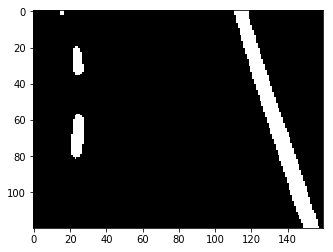

In [2]:
img = mpimg.imread('NewTest/prank4.jpg')
#img = mpimg.imread("Raspi_images/New/NewNew/NewNewNew/a (35).jpg")
#thresh,_,Minv,_ = perspective_transform(pipeline_threshold(img))
thresh = pipeline_threshold(img)
plt.imshow(thresh, cmap='gray')
print(thresh.shape)
warped = thresh
print(thresh[90:, 155])

In [ ]:
lineThickness = 10
prank = cv2.line(warped, (145, 119), (146, 119), (0,255,0), lineThickness, lineType=2)
plt.imshow(prank, cmap='gray')

prank = np.expand_dims(prank, axis=-1)
cv2.imshow("ada", prank)
cv2.waitKey(0)

In [ ]:
def detect_edges(image, low_threshold=100, high_threshold=300):
    
    v = np.median(image)
    sigma = 0.33
    #---- apply automatic Canny edge detection using the computed median----
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    #print("lower: ", lower)
    #print("upper: ", upper)
    edged = cv2.Canny(image, lower, upper)
    return edged
    #return cv2.Canny(image, low_threshold, high_threshold)
    #return cv2.Canny(image, 0, 0)
edges = detect_edges(warped)
plt.imshow(edges, cmap='gray')

True
False


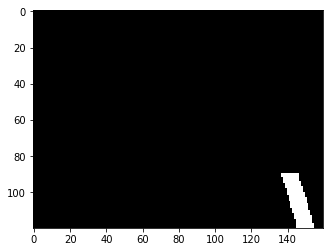

In [9]:
def region_of_interest(canny, prank1=False, prank2=False):
    height = canny.shape[0]
    width = canny.shape[1]
    mask = np.zeros_like(canny)
    print(prank1)
    print(prank2)
    #triangle = np.array([[
    #(70, height),
    #(140, 0),
    #(160, height),
    #]], np.int32)
    if prank1 == True:
        rows, cols = canny.shape[:2]
        bottom_left  = [cols*0.5, rows*1]
        top_left     = [cols*0.5, rows*0.75]
        bottom_right = [cols*1, rows*1]
        top_right    = [cols*1, rows*0.75]
        #bottom_left  = [cols*0, rows*1]
        #top_left     = [cols*0, rows*0.75]
        #bottom_right = [cols*0.5, rows*1]
        #top_right    = [cols*0.5, rows*0.75]
        
    if prank2 == True:
        rows, cols = canny.shape[:2]
        bottom_left  = [cols*0.5, rows*0.75]
        top_left     = [cols*0.5, rows*0.55]
        bottom_right = [cols*1, rows*0.75]
        top_right    = [cols*1, rows*0.55]
        #bottom_left  = [cols*0, rows*0.75]
        #top_left     = [cols*0, rows*0.55]
        #bottom_right = [cols*0.5, rows*0.75]
        #top_right    = [cols*0.5, rows*0.55]
    
    #bottom_left  = [cols*0.5, rows*1]
    #top_left     = [cols*0.5, rows*0.5]
    #bottom_right = [cols*1, rows*1]
    #top_right    = [cols*1, rows*0.5]
    # the vertices are an array of polygons (i.e array of arrays) and the data type must be integer
    vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
    cv2.fillPoly(mask, vertices, 255)
    masked_image = cv2.bitwise_and(canny, mask)
    return masked_image

thresh_roi = region_of_interest(thresh, True, False)
#print(thresh_roi.shape)
plt.imshow(thresh_roi, cmap='gray')
plt.show()

False
True


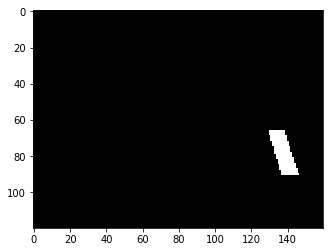

In [10]:
thresh_roi2 = region_of_interest(thresh, False, True)
#print(thresh_roi.shape)
plt.imshow(thresh_roi2, cmap='gray')
plt.show()

In [ ]:
_, countours, hierarchy = cv2.findContours(thresh_roi, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
print(len(countours))
object_area = 0
object_x = 0
object_y = 0

for contour in countours:
    x, y, width, height = cv2.boundingRect(contour)
    blackbox2 = cv2.boundingRect(contour)
    found_area = width * height
    center_x = x + (width / 2)
    center_y = y + (height / 2)
    
    M = cv2.moments(contour)
    cx = int(M['m10']/M['m00'])
    cy = int(M['m01']/M['m00'])
    #print("cx: ", cx)
    #print("cy: ", cy)
    
    if object_area < found_area:
        object_area = found_area
        object_x = center_x
        object_y = center_y

    print(x)
    print(y)

    print(center_x)
    print(center_y)
    #print(found_area)
if object_area > 0:
    ball_location = [object_area, object_x, object_y]
    blackbox = cv2.minAreaRect(contour)
    #print(blackbox)

else:
    ball_location = None
        
minimum_area = 50
maximum_area = 15000

image_width = 320/2

center_image_x = 150
center_image_y = 119
#print("center_image_x: ", center_image_x)# + (image_width/6))
print("ball_location[1]: ", ball_location[1])

if ball_location != None:
    if (ball_location[0] > minimum_area) and (ball_location[0] < maximum_area):
        if ball_location[1] > (center_image_x+5):# + (image_width/3)):
            #robot.right(turn_speed)
            print("Turning right")
        elif ball_location[1] < (center_image_x-5):
            #robot.left(turn_speed)
            print("Turning left")
            
        else:
            #robot.forward(forward_speed)
            print("Forward")
    elif (ball_location[0] < minimum_area):
        #robot.left(turn_speed)
        print("Target isn't large enough, searching")
            
    else:
        #robot.stop()
        print("Target large enough, stopping")
else:
    #robot.left(turn_speed)
    print("Target not found, searching")
#print(blackbox2)
cv2.rectangle(img,(x,y),(x+width,y+height),(0,255,0),2)
cv2.imshow("img", img)
cv2.waitKey(0)
   

In [11]:
_,contours_blk, hierarchy_blk = cv2.findContours(thresh_roi.copy(),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
_,contours_blk2, hierarchy_blk2 = cv2.findContours(thresh_roi2.copy(),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

print(len(contours_blk))
print(len(contours_blk2))

image_width = 160

contours_blk_len = len(contours_blk)
contours_blk_len2 = len(contours_blk2)
default_angle = -18

if contours_blk_len > 0:
    if contours_blk_len == 1:
        blackbox = cv2.minAreaRect(contours_blk[0])
        (x_min, y_min), (w_min, h_min), ang = blackbox
        print("ang1: ", ang)
        if ang < 0:
            ang=ang-(default_angle)
        if ang+(default_angle) > 0:
            ang=ang+default_angle
        

        if ang < -45:
            ang = ang + 90
        #if w_min < h_min and ang > 0:
        #    ang = (90-ang)*-1
        if w_min > h_min and ang < 0:
            ang = ang + 90 
        setpoint = image_width - 10
        error = setpoint - x_min
        total_error = (error) + ang*0.75
        box = cv2.boxPoints(blackbox)
        box = np.int0(box)
        cv2.drawContours(img,[box],0,(0,0,255),2)

    if contours_blk_len2 > 0:
        blackbox2 = cv2.minAreaRect(contours_blk2[0])
        (x_min2, y_min2), (w_min2, h_min2), ang2 = blackbox2
        print("ang2: ", ang2)
        if ang2 <= 0.0:
            ang2=ang2-(default_angle)
        if ang2+(default_angle) > 0:
            ang2=ang2+default_angle
        
    
        if ang2 < -45:
            ang2 = ang2 + 90
        #if w_min2 < h_min2 and ang2 > 0:
        #    ang2 = (90-ang2)*-1
        if w_min2 > h_min2 and ang2 < 0:
            ang2 = ang2 + 90
        setpoint2 = 141.5
        error2 = setpoint2 - x_min2
        total_error2 = (error2) + ang2*0.75
        box2 = cv2.boxPoints(blackbox2)
        box2 = np.int0(box2)
        cv2.drawContours(img,[box2],0,(0,0,255),2)

    print("angle1: ", ang)
    print("angle2: ", ang2)

    #print("w_min: ", w_min)
    #print("w_min2: ", w_min2)

    #print("h_min: ", h_min)
    #print("h_min2: ", h_min2)

    print("x_min: ", x_min)
    print("x_min2: ", x_min2)

    #print("y_min:", y_min)
    #print("y_min2:", y_min2)

    
    if contours_blk_len == 1 and contours_blk_len2 < 1:
        total_error_avg = total_error
        print("total_error_avg1: ", total_error_avg)
    
    if contours_blk_len < 1 and contours_blk_len2 == 1:
        total_error_avg = total_error2
        print("total_error_avg2: ", total_error_avg)
     
    if (contours_blk_len) == 1 and (contours_blk_len2) == 1:
        total_error_avg = (total_error + total_error2)/2.0
        print("total_error_avg3: ", total_error_avg)

    if total_error_avg < 0:
        print("steer left")
    if total_error_avg > 0:
        print("steer right")
    #print("blackbox: ", blackbox)
    #print("angle: ", ang)
    #print("angle2: ", ang2)
    #setpoint = image_width - 10
    #setpoint2 = 141.5
    #print("setpoint: ", setpoint)
    
    
    print("error: ",error)
    print("error2: ",error2)

    
    

    print("total_error: ", total_error)
    print("total_error2: ", total_error2)

    
    #print("total_error_avg: ", total_error_avg)
    #rect = cv2.minAreaRect(cnt)
    

    
    #cv2.putText(img,str(ang),(5, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (200, 0, 255), 1)
    #cv2.putText(img,str(total_error_avg),(10, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 200, 0), 1)
    cv2.imshow("img", img)
    cv2.waitKey(0)

1
1
('ang1: ', -16.389541625976562)
('ang2: ', -18.43494987487793)
('angle1: ', 1.6104583740234375)
('angle2: ', -0.4349498748779297)
('x_min: ', 145.6082763671875)
('x_min2: ', 137.5500030517578)
('total_error_avg3: ', 4.611675977706909)
steer right
('error: ', 4.3917236328125)
('error2: ', 3.9499969482421875)
('total_error: ', 5.599567413330078)
('total_error2: ', 3.6237845420837402)


In [ ]:
_,contours_blk, hierarchy_blk = cv2.findContours(thresh_roi.copy(),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
_,contours_blk2, hierarchy_blk2 = cv2.findContours(thresh_roi2.copy(),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

print(len(contours_blk))
print(len(contours_blk2))

image_width = 160

contours_blk_len = len(contours_blk)
contours_blk_len2 = len(contours_blk2)

if contours_blk_len > 0 or contours_blk_len2 > 0:
    if contours_blk_len == 1 :
        blackbox = cv2.minAreaRect(contours_blk[0])
        blackbox2 = cv2.minAreaRect(contours_blk2[0])
    else:
        canditates=[]
        off_bottom = 0  
        for con_num in range(contours_blk_len):
            blackbox = cv2.minAreaRect(contours_blk[con_num])
            (x_min, y_min), (w_min, h_min), ang = blackbox
            box = cv2.boxPoints(blackbox)
            (x_box,y_box) = box[0]
            if y_box > 118 :
                off_bottom += 1
            canditates.append((y_box,con_num,x_min,y_min))
        canditates = sorted(canditates)
        if off_bottom > 1:
            canditates_off_bottom=[]
            for con_num in range ((contours_blk_len - off_bottom), contours_blk_len):
                (y_highest,con_highest,x_min, y_min) = canditates[con_num]
                total_distance = (abs(x_min - x_last)**2 + abs(y_min - y_last)**2)**0.5
                canditates_off_bottom.append((total_distance,con_highest))
            canditates_off_bottom = sorted(canditates_off_bottom)         
            (total_distance,con_highest) = canditates_off_bottom[0]         
            blackbox = cv2.minAreaRect(contours_blk[con_highest])   
        else:
            (y_highest,con_highest,x_min, y_min) = canditates[contours_blk_len-1]
            blackbox = cv2.minAreaRect(contours_blk[con_highest])    

(x_min, y_min), (w_min, h_min), ang = blackbox
(x_min2, y_min2), (w_min2, h_min2), ang2 = blackbox2

print("angle1: ", ang)
print("angle2: ", ang2)

#print("w_min: ", w_min)
#print("w_min2: ", w_min2)

#print("h_min: ", h_min)
#print("h_min2: ", h_min2)

print("x_min: ", x_min)
print("x_min2: ", x_min2)

#print("y_min:", y_min)
#print("y_min2:", y_min2)

default_angle = -18
if ang < 0:
    ang=ang-(default_angle)
if ang+(default_angle) > 0:
    ang=ang+default_angle
print("ang1: ", ang)

if ang < -45:
    ang = ang + 90
#if w_min < h_min and ang > 0:
#    ang = (90-ang)*-1
if w_min > h_min and ang < 0:
    ang = ang + 90 

    
if ang2 <= 0.0:
    ang2=ang2-(default_angle)
if ang2+(default_angle) > 0:
    ang2=ang2+default_angle
print("ang2: ", ang2)

if ang2 < -45:
    ang2 = ang2 + 90
#if w_min2 < h_min2 and ang2 > 0:
#    ang2 = (90-ang2)*-1
if w_min2 > h_min2 and ang2 < 0:
    ang2 = ang2 + 90 



#print("blackbox: ", blackbox)
print("angle: ", ang)
print("angle2: ", ang2)
setpoint = image_width - 10
setpoint2 = 141.5
#print("setpoint: ", setpoint)
error = setpoint - x_min
error2 = setpoint2 - x_min2
print("error: ",error)
print("error2: ",error2)

total_error = (error) + ang*0.75
total_error2 = (error2) + ang2*0.75

#print("total_error: ", total_error)
#print("total_error2: ", total_error2)

total_error_avg = (total_error + total_error2)/2.0
print("total_error_avg: ", total_error_avg)
#rect = cv2.minAreaRect(cnt)
box = cv2.boxPoints(blackbox)
box2 = cv2.boxPoints(blackbox2)

box = np.int0(box)
box2 = np.int0(box2)

cv2.drawContours(img,[box],0,(0,0,255),2)
cv2.drawContours(img,[box2],0,(0,0,255),2)
cv2.putText(img,str(ang),(5, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (200, 0, 255), 1)
cv2.putText(img,str(total_error_avg),(10, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 200, 0), 1)
cv2.imshow("img", img)
cv2.waitKey(0)

In [ ]:
edges = region_of_interest(edges)
plt.imshow(edges, cmap='gray')

In [ ]:
def hough_lines(image):
    """
    `image` should be the output of a Canny transform.
    
    Returns hough lines (not the image with lines)
    """
    return cv2.HoughLinesP(image, rho=1, theta=np.pi/180, threshold=10, minLineLength=10, maxLineGap=50)
list_of_lines = (hough_lines(edges))
print(np.asarray(list_of_lines).shape)
#print(list_of_lines[4])
print(list_of_lines)
#plt.imshow(hough, cmap='gray')

In [ ]:
def display_lines(image, lines):
    line_image = np.zeros_like(image)
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line.reshape(4)
            cv2.line(line_image, (x1, y1), (x2, y2), (255, 0, 100), 2)
    return line_image

In [ ]:
line_image = display_lines(warped, list_of_lines)
plt.imshow(line_image, cmap='gray')

In [ ]:
print(line_image.shape)

In [ ]:
warped2,_,Minv2,_ = perspective_transform((img))
warped2 = cv2.cvtColor(warped2, cv2.COLOR_RGB2GRAY)
print(warped2.shape)
print(line_image.shape)
combo_image = cv2.addWeighted(warped, 0.8, line_image, 1, 1)
plt.imshow(combo_image, cmap='gray')

In [ ]:
def average_slope_intercept(image, lines):
    left_fit = []
    right_fit = []
    for line in lines:
        x1, y1, x2, y2 = line.reshape(4)
        parameters = np.polyfit((x1, x2), (y1, y2), 1)
        print("slope: ", parameters[0])
        print("intercept : ",parameters[1])
        
        slope = parameters[0]
        intercept = parameters[1]
        #if slope < 0:
        #    left_fit.append((slope, intercept))
        #else:
        #    right_fit.append((slope, intercept))
        right_fit.append((slope, intercept))
        #print(right_fit, left_fit)
    left_fit_average = np.average(left_fit, axis = 0)
    right_fit_average = np.average(right_fit, axis = 0)
    print("right_fit_average_: ", right_fit_average)
    #print("left_fit_average_: ", left_fit_average)

    #prank = np.array(left_fit_average)
    #prank2 = np.array(right_fit_average)
    
    #left_line = make_coordinates(image, left_fit_average)

    right_line = make_coordinates(image, right_fit_average)

    return np.array([right_line])
            
averaged_lines = average_slope_intercept(warped, list_of_lines)
print(averaged_lines)

In [ ]:
def make_coordinates(image, line_parameters):
    slope, intercept = line_parameters
    y1 = image.shape[0]
    y2 = int(y1*(4/5))
    x1 = int((y1-intercept)/slope)
    x2 = int((y2-intercept)/slope)
    return np.array([x1, y1, x2, y2])


In [ ]:
warped2,_,Minv2,_ = perspective_transform((img))
warped2 = cv2.cvtColor(warped2, cv2.COLOR_RGB2GRAY)
#print(warped2.shape)
#print(line_image.shape)


In [ ]:
line_image = display_lines(warped, averaged_lines)
plt.imshow(line_image, cmap = 'gray')
print(line_image.shape)
plt.show()

In [ ]:
prank = np.expand_dims(line_image, axis=-1)
print(prank.shape)
cv2.imshow("prank", prank)
cv2.waitKey(0)

In [ ]:

combo_image = cv2.addWeighted(warped, 0.8, line_image, 1, 1)
plt.imshow(combo_image, cmap='gray')
plt.show()

In [ ]:
#hough = np.asarray(list_of_lines)
#print(hough[1,0,0])

In [ ]:
image_copy = np.copy(image)
warped2,_ , _ ,_  = perspective_transform(image_copy)

In [ ]:
def draw_lines(image, lines, color=[255, 0, 0], thickness=2, make_copy=True):
    # the lines returned by cv2.HoughLinesP has the shape (-1, 1, 4)
    if make_copy:
        image = np.copy(image) # don't want to modify the original
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(image, (x1, y1), (x2, y2), color, thickness)
    return image

color=[255, 0, 0]
thickness=2
#prank = draw_lines(img, list_of_lines[1])
image_copy = np.copy(image)
cv2.line(warped2, (115, 115), (115, 0), color, thickness)
cv2.line(warped2, (133, 0), (135, 119), color, thickness)

plt.imshow(warped2, cmap='gray')
#line_images = []
#for image, lines in zip(test_images, list_of_lines):
#    line_images.append(draw_lines(image, lines))
    
#show_images(line_images)

In [ ]:
def average_slope_intercept(lines):
    left_lines    = [] # (slope, intercept)
    left_weights  = [] # (length,)
    right_lines   = [] # (slope, intercept)
    right_weights = [] # (length,)
    
    for line in lines:
        for x1, y1, x2, y2 in line:
            if x2==x1:
                continue # ignore a vertical line
            slope = (y2-y1)/(x2-x1)
            intercept = y1 - slope*x1
            length = np.sqrt((y2-y1)**2+(x2-x1)**2)
            if slope < 0: # y is reversed in image
                left_lines.append((slope, intercept))
                left_weights.append((length))
            else:
                right_lines.append((slope, intercept))
                right_weights.append((length))
    
    # add more weight to longer lines    
    left_lane  = np.dot(left_weights,  left_lines) /np.sum(left_weights)  if len(left_weights) >0 else None
    right_lane = np.dot(right_weights, right_lines)/np.sum(right_weights) if len(right_weights)>0 else None
    
    return left_lane, right_lane # (slope, intercept), (slope, intercept)

print(hough)

left_lines    = [] # (slope, intercept)
left_weights  = [] # (length,)
right_lines   = [] # (slope, intercept)
right_weights = [] # (length,)

slope = (y2-y1)/(x2-x1)
intercept = y1 - slope*x1
length = np.sqrt((y2-y1)**2+(x2-x1)**2)
if slope < 0: # y is reversed in image
    left_lines.append((slope, intercept))
    left_weights.append((length))
else:
    right_lines.append((slope, intercept))
    right_weights.append((length))
    
left_lane  = np.dot(left_weights,  left_lines) /np.sum(left_weights)  if len(left_weights) >0 else None
right_lane = np.dot(right_weights, right_lines)/np.sum(right_weights) if len(right_weights)>0 else None
    